Phan biet cac loai te bao mau (Eosinophil, Lymphocyte, Monocyte, and Neutrophil). Nham muc dich ho tro vao linh vuc y hoc khi can xet nghiem 1 so luong lon mau mau.

### Import libraries

In [ ]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from PIL import Image
from skimage import transform
from tqdm import tqdm
import cv2

### Read the data

In [ ]:
#Reading the input image
inp_image = transform.resize(
          cv2.imread(r'Dataset/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1169.jpeg'), 
          (80, 80, 3));

In [ ]:
#Converting into an numpy array
inp_image = np.array(inp_image);

The shape of the image is :  (80, 80, 3) 

The image is :


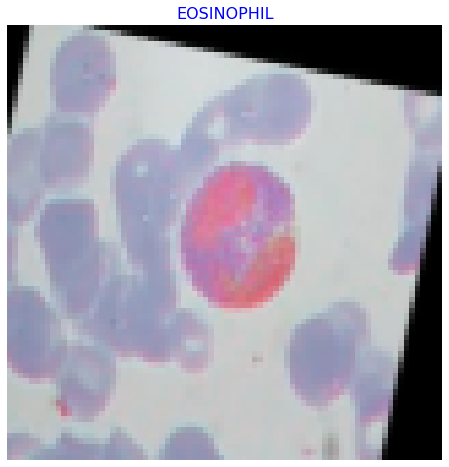

In [ ]:
print("The shape of the image is : " , inp_image.shape , "\n")
print("The image is :")

fig = plt.subplots(1,figsize=(8,8));
plt.axis('off');
plt.title("EOSINOPHIL",
          fontsize = 16,
          color = 'blue');
plt.imshow(inp_image);

In [ ]:
categories = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

In [ ]:
# resize 120x120
image_size = (120,120)

In [ ]:
def load_data():
    
    datasets = ['Dataset/dataset2-master/dataset2-master/images/TRAIN',
                'Dataset/dataset2-master/dataset2-master/images/TEST'
                ]
    images = []
    labels = []
    count =0
    for dataset in datasets:
        
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                 
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                
                # resize the image
                image = cv2.resize(image, image_size)
                
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [ ]:
images, labels = load_data()

100%|██████████| 624/624 [00:02<00:00, 254.42it/s]


In [ ]:
# Shuffle
images, labels = shuffle(images, labels, random_state=17)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [ ]:
n_train = y_train.shape[0]
n_val = y_val.shape[0]
n_test = y_test.shape[0]

In [ ]:
print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

Number of training examples: 9955
Number of validation examples: 1245
Number of testing examples: 1244


In [ ]:
# Normalizing
X_train = X_train / 255.0 
X_val = X_val / 255.0
X_test = X_test / 255.0

### Buil model

In [ ]:
model = Sequential()
# first conv layer
model.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,120,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
# second conv layer
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Third Conv Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# FC layer
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units = 4 , activation = 'softmax'))

In [ ]:
# Compile
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        1

In [ ]:
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   min_delta=1, 
                   patience=50,
                   verbose=1,
                   restore_best_weights=True
                   )

In [ ]:
mc = ModelCheckpoint('/content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_CNN_cau3.h5', 
                     monitor='val_accuracy', 
                     mode='max',
                     verbose=1,
                     save_best_only=True,
                     )

In [ ]:
history = model.fit(
    x = X_train, y=y_train,
    use_multiprocessing = True,
    batch_size=32,
    epochs=200,
    workers = os.cpu_count(),
    callbacks=[es,mc],
    validation_data=(X_val,y_val),
    verbose=1
)

Epoch 1/200
310/312 [============================>.] - ETA: 0s - loss: 1.3872 - accuracy: 0.2518
Epoch 1: val_accuracy improved from -inf to 0.24016, saving model to /content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_CNN_cau3.h5
312/312 [==============================] - 5s 15ms/step - loss: 1.3872 - accuracy: 0.2517 - val_loss: 1.3867 - val_accuracy: 0.2402
Epoch 2/200
308/312 [============================>.] - ETA: 0s - loss: 1.3864 - accuracy: 0.2427
Epoch 2: val_accuracy improved from 0.24016 to 0.24578, saving model to /content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_CNN_cau3.h5
312/312 [==============================] - 4s 13ms/step - loss: 1.3864 - accuracy: 0.2432 - val_loss: 1.3865 - val_accuracy: 0.2458
Epoch 3/200
309/312 [============================>.] - ETA: 0s - loss: 1.3863 - accuracy: 0.2550
Epoch 3: val_accuracy did not improve from 0.24578
312/312 [==

### Evaluate

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_CNN_cau3.h5')

In [ ]:
# Test
results = model.evaluate(X_test, y_test)
print("Loss of the model  with test data is: ", results[0])
print("Accuracy of the model with test data is: ", results[1]*100, "%")

39/39 [==============================] - 0s 7ms/step - loss: 0.1176 - accuracy: 0.9703
Loss of the model  with test data is:  0.11756777763366699
Accuracy of the model with test data is:  97.02572226524353 %


In [ ]:
# Train
results = model.evaluate(X_train, y_train)
print("Loss of the model with train data is: ", results[0])
print("Accuracy of the model with train data is: ", results[1]*100, "%")

312/312 [==============================] - 2s 6ms/step - loss: 0.1178 - accuracy: 0.9656
Loss of the model with train data is:  0.11783738434314728
Accuracy of the model with train data is:  96.5645432472229 %


In [ ]:
# Validate
results = model.evaluate(X_val, y_val)
print("Loss of the model with validate data is: ", results[0])
print("Accuracy of the model with validate data is: ", results[1]*100, "%")

39/39 [==============================] - 0s 9ms/step - loss: 0.1102 - accuracy: 0.9679
Loss of the model with validate data is:  0.11022502928972244
Accuracy of the model with validate data is:  96.78714871406555 %


Nhan xet: Model co do chinh xac cao, co the su dung duoc.

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred[:5]

39/39 [==============================] - 1s 8ms/step


array([0, 3, 0, 1, 1])

In [ ]:
print(classification_report(
    y_test, 
    y_pred, 
    target_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
)

              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.97      0.95       335
  LYMPHOCYTE       1.00      0.99      0.99       304
    MONOCYTE       1.00      0.99      0.99       308
  NEUTROPHIL       0.96      0.94      0.95       297

    accuracy                           0.97      1244
   macro avg       0.97      0.97      0.97      1244
weighted avg       0.97      0.97      0.97      1244



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, 
                  index = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], 
                  columns = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
                  )
cm

,EOSINOPHIL,LYMPHOCYTE,MONOCYTE,NEUTROPHIL
EOSINOPHIL,324,0,0,11
LYMPHOCYTE,3,301,0,0
MONOCYTE,2,1,304,1
NEUTROPHIL,19,0,0,278


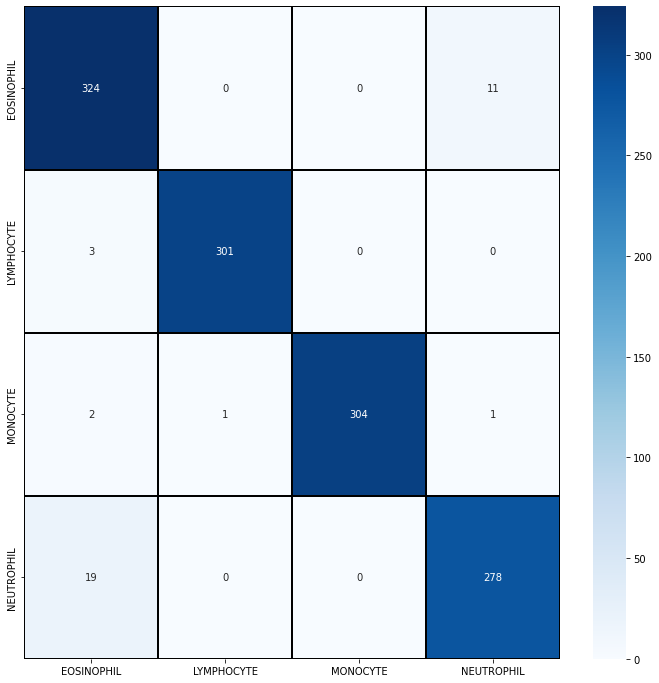

In [ ]:
plt.figure(figsize = (12,12))
sns.heatmap(
    cm, 
    cmap = 'Blues', 
    linecolor = 'black', 
    linewidth = 1, 
    annot = True, 
    fmt = '')
plt.show()

Nhan xet: Ket qua tuong doi tot

### Predict

In [ ]:
from tensorflow.keras.preprocessing import image
from IPython.display import Image

In [ ]:
def print_result(img_path):
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                
  #resize the image
  image = cv2.resize(image, image_size)
  image = np.array(image, dtype = 'float32')
  image = image/255
  image = np.expand_dims(image, axis=0)

  result = model.predict(image)
  # result = np.argmax(result,axis=1)
  print(result)
  
  if result[0][0] <= 0.5:
    prediction = categories[0]
  elif result[0][0] > 0.5 & result[0][0] <= 1.5:
    prediction = categories[1]
  elif result[0][0] > 1.5 & result[0][0] <= 2.5:
    prediction = categories[2]
  elif result[0][0] > 2.5:
    prediction = categories[3]
  print(prediction)

In [ ]:
#Estinophil
img_path = '/content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg'

1/1 [==============================] - 0s 16ms/step
[[4.5164591e-01 3.1181844e-05 1.0168891e-03 5.4730600e-01]]
EOSINOPHIL


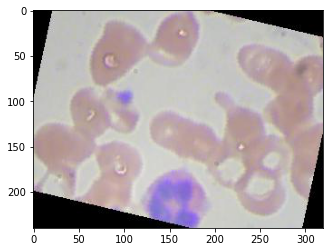

In [ ]:
img=mpimg.imread('/content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
print_result(img_path)
implot=plt.imshow(img)
plt.show()

Nhan xet: Model hoat dong tot. Ket qua chinh xac